<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/chords_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip uninstall -y gensim

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0


In [3]:
pip install gensim

     |████████████████████████████████| 24.1 MB 2.7 kB/s 


In [4]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 27.5 MB/s 
     |████████████████████████████████| 15.7 MB 59 kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=a32069ec34815108518405b2508f284d47013e41634bdce89686a0ce92dc120d
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into

In [1]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [87]:
print(gensim.__version__)

4.1.2


# Initialization

## Download the Data

With repetitions in Chords:

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YvpsEo6OGObpFsxgfZ_nPtgs1u59ydJy' -O input_seq.txt

--2021-11-10 21:51:31--  https://docs.google.com/uc?export=download&id=1YvpsEo6OGObpFsxgfZ_nPtgs1u59ydJy
Resolving docs.google.com (docs.google.com)... 172.217.212.113, 172.217.212.102, 172.217.212.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.212.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0rde6ejg4tskl95dp8jorll0o3hi19el/1636581075000/14329102864480165501/*/1YvpsEo6OGObpFsxgfZ_nPtgs1u59ydJy?e=download [following]
--2021-11-10 21:51:31--  https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0rde6ejg4tskl95dp8jorll0o3hi19el/1636581075000/14329102864480165501/*/1YvpsEo6OGObpFsxgfZ_nPtgs1u59ydJy?e=download
Resolving doc-10-4c-docs.googleusercontent.com (doc-10-4c-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Connecting to doc-10-4c-docs.googleusercontent.com (doc-10

No repetitions in Chords:

In [5]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pyPEWnD8aNETZNHI-tN9siHgr3ZSfs9a' -O input_seq.txt

--2021-11-10 21:51:33--  https://docs.google.com/uc?export=download&id=1pyPEWnD8aNETZNHI-tN9siHgr3ZSfs9a
Resolving docs.google.com (docs.google.com)... 172.217.212.113, 172.217.212.102, 172.217.212.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.212.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u7ash0i3n0lflc7tv9ab0ge3mq5nl6e3/1636581075000/14329102864480165501/*/1pyPEWnD8aNETZNHI-tN9siHgr3ZSfs9a?e=download [following]
--2021-11-10 21:51:34--  https://doc-08-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u7ash0i3n0lflc7tv9ab0ge3mq5nl6e3/1636581075000/14329102864480165501/*/1pyPEWnD8aNETZNHI-tN9siHgr3ZSfs9a?e=download
Resolving doc-08-4c-docs.googleusercontent.com (doc-08-4c-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Connecting to doc-08-4c-docs.googleusercontent.com (doc-08

With repetitions, full chords:

In [6]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pyPEWnD8aNETZNHI-tN9siHgr3ZSfs9a' -O input_seq.txt

--2021-11-10 21:51:37--  https://docs.google.com/uc?export=download&id=1pyPEWnD8aNETZNHI-tN9siHgr3ZSfs9a
Resolving docs.google.com (docs.google.com)... 172.217.212.100, 172.217.212.113, 172.217.212.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.212.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u7ash0i3n0lflc7tv9ab0ge3mq5nl6e3/1636581075000/14329102864480165501/*/1pyPEWnD8aNETZNHI-tN9siHgr3ZSfs9a?e=download [following]
--2021-11-10 21:51:38--  https://doc-08-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u7ash0i3n0lflc7tv9ab0ge3mq5nl6e3/1636581075000/14329102864480165501/*/1pyPEWnD8aNETZNHI-tN9siHgr3ZSfs9a?e=download
Resolving doc-08-4c-docs.googleusercontent.com (doc-08-4c-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Connecting to doc-08-4c-docs.googleusercontent.com (doc-08

Download the file with the meta data from Google Drive:

In [7]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Qs_SNXKBCeHOZO4VTwIPLR6OsPzEjk6q' -O input_meta.csv

--2021-11-10 21:51:41--  https://docs.google.com/uc?export=download&id=1Qs_SNXKBCeHOZO4VTwIPLR6OsPzEjk6q
Resolving docs.google.com (docs.google.com)... 172.217.212.100, 172.217.212.139, 172.217.212.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.212.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/enq9lpkggpkanq6k1v1g9126qhj9k5cl/1636581075000/14329102864480165501/*/1Qs_SNXKBCeHOZO4VTwIPLR6OsPzEjk6q?e=download [following]
--2021-11-10 21:51:41--  https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/enq9lpkggpkanq6k1v1g9126qhj9k5cl/1636581075000/14329102864480165501/*/1Qs_SNXKBCeHOZO4VTwIPLR6OsPzEjk6q?e=download
Resolving doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Connecting to doc-14-4c-docs.googleusercontent.com (doc-14

### Chords Data

In [8]:
path_to_file = '/content/input_seq.txt'

with open(path_to_file) as f: 
  lines = f.read().splitlines()

In [9]:
data = [line.split(' ') for line in lines]

In [10]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]


def list_to_ngrams(data, n=2, sep='-'):
  out = []
  for row in data:
    out.append(ngrams(row, n, sep))

  return out

In [11]:
#data = list_to_ngrams(data, 3)

### Meta Data

In [12]:
meta = pd.read_csv('input_meta.csv', sep='\t')
meta.head(5)

,id,file_name,title,composer,year,year_truncated,tonality,tune_key,tune_mode,structure,num_bars,time_signature,cycle_fifths_order,style,musicbrainz_id,wikidata_id,wikidata_allmusic,wiki_link,wikidata_description,lyricist
0,0,dataset/jazz1350/26-2.xml,26-2,John Coltrane,1960.0,1960.0,F major,F,major,AABA,32.0,4/4,-1.0,Medium Up Swing,eb51f0dd-c9a6-3849-b135-9cfaa7a90396,NaN,NaN,NaN,NaN,NaN
1,1,dataset/jazz1350/500 Miles High.xml,500 Miles High,Chick Corea,1978.0,1978.0,E minor,E,minor,NaN,26.0,4/4,1.0,Bossa Nova,1e03810a-6632-35ee-959b-dfd244be19b5,NaN,NaN,NaN,NaN,Neville Potter
2,2,dataset/jazz1350/502 Blues.xml,502 Blues,Jimmy Rowles,1962.0,1962.0,A minor,A,minor,NaN,32.0,3/4,0.0,Waltz,cff33fd3-7be2-3559-b06a-1d5cee201939,NaN,NaN,NaN,NaN,NaN
3,3,dataset/jazz1350/52nd Street Theme.xml,52nd Street Theme,Thelonious Monk,1944.0,1944.0,C major,C,major,AABA,32.0,4/4,0.0,Up Tempo Swing,aaa19faf-298a-3e89-9599-6a30866cd7fd,NaN,NaN,NaN,NaN,NaN
4,4,dataset/jazz1350/9.20 Special.xml,9.20 Special,Earle Warren,1941.0,1941.0,C major,C,major,AABA,32.0,4/4,0.0,Medium Swing,67755649-b89e-409c-ad6b-488f4cd455a5,Q16824165,NaN,https://en.wikipedia.org/wiki/9:20_Special,1941 song,William Engvick


In [13]:
titles = meta.loc[:, ['id', 'title']].drop_duplicates()
titles.set_index('id', inplace=True)
titles

,title
id,
0,26-2
1,500 Miles High
2,502 Blues
3,52nd Street Theme
4,9.20 Special
...,...
1807,You're Foolin' Someone
1808,You're Lucky To Me
1809,You're Nobody Till Somebody Loves You


In [14]:
assert len(data) == len(titles)

# Train LDA Model

In [61]:
from gensim.test.utils import common_texts
import gensim.models as models
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary

# Create a corpus from a list of texts
id2word = corpora.Dictionary(data)

2021-11-10 22:09:07,151 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-10 22:09:07,232 : INFO : built Dictionary(478 unique tokens: ['AM7', 'Am7', 'B7', 'Bbm7', 'Bm7']...) from 1812 documents (total 82790 corpus positions)
2021-11-10 22:09:07,235 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(478 unique tokens: ['AM7', 'Am7', 'B7', 'Bbm7', 'Bm7']...) from 1812 documents (total 82790 corpus positions)", 'datetime': '2021-11-10T22:09:07.235040', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [62]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(tune) for tune in data]

In [286]:
%%time
TOTAL_TOPICS = 30
lda_model = gensim.models.LdaModel(corpus=corpus, 
                                   id2word=id2word, 
                                   chunksize=200, 
                                   alpha='auto', 
                                   eta='auto', 
                                   #eta=0.1,
                                   random_state=42,
                                   #iterations=500, 
                                   num_topics=TOTAL_TOPICS, 
                                   passes=30, 
                                   per_word_topics=True,
                                   eval_every=None,
                                   update_every=0,  # batch learning, start from scratch everytime (<> online learning)
                                   )

2021-11-10 22:49:59,925 : INFO : using autotuned alpha, starting with [0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335]
2021-11-10 22:49:59,930 : INFO : using serial LDA version on this node
2021-11-10 22:49:59,937 : INFO : running batch LDA training, 30 topics, 30 passes over the supplied corpus of 1812 documents, updating model once every 1812 documents, evaluating perplexity every 0 documents, iterating 50x with a convergence threshold of 0.001000
2021-11-10 22:49:59,939 : INFO : PROGRESS: pass 0, at document #200/1812
2021-11-10 22:50:00,124 : INFO : optimized alpha [0.028591335, 0.036608968, 0.030418376, 0.028966192, 0.035224244, 0.029687244, 0.0

CPU times: user 42 s, sys: 828 ms, total: 42.8 s
Wall time: 44.4 s


In [287]:
lda_model.print_topics()

2021-11-10 22:50:44,295 : INFO : topic #17 (0.009): 0.281*"Am9" + 0.180*"Bb9" + 0.103*"Dm9" + 0.039*"G#9(+#11)" + 0.026*"FM7" + 0.026*"F9(+#11)" + 0.022*"C#7alt" + 0.021*"Ebm9" + 0.020*"Bbm9" + 0.020*"G#M7"
2021-11-10 22:50:44,297 : INFO : topic #16 (0.009): 0.123*"Dm7" + 0.099*"G7" + 0.099*"CM7" + 0.067*"Am7" + 0.066*"D7" + 0.049*"Ebdim" + 0.044*"E7alt" + 0.028*"FM7" + 0.017*"C7" + 0.014*"Bb7"
2021-11-10 22:50:44,299 : INFO : topic #22 (0.010): 0.257*"Cdim7" + 0.079*"G13(+b9)" + 0.067*"B7alt" + 0.042*"Dm9" + 0.042*"G13sus4" + 0.033*"C6" + 0.025*"Em7" + 0.024*"Gm7" + 0.023*"Bb13" + 0.023*"A7sus4"
2021-11-10 22:50:44,301 : INFO : topic #14 (0.012): 0.301*"Gaug" + 0.074*"C7(+b9)sus4" + 0.069*"Gm6" + 0.069*"D7" + 0.048*"E9" + 0.046*"G#dim" + 0.044*"Aaug" + 0.041*"FM9" + 0.028*"C7" + 0.027*"C"
2021-11-10 22:50:44,304 : INFO : topic #24 (0.013): 0.107*"D13" + 0.105*"C13" + 0.091*"F9" + 0.074*"D7sus4" + 0.061*"G9" + 0.047*"Gm9" + 0.045*"Gm11" + 0.043*"Fm9" + 0.040*"G#9" + 0.036*"G13"
2021-11

[(17,
  '0.281*"Am9" + 0.180*"Bb9" + 0.103*"Dm9" + 0.039*"G#9(+#11)" + 0.026*"FM7" + 0.026*"F9(+#11)" + 0.022*"C#7alt" + 0.021*"Ebm9" + 0.020*"Bbm9" + 0.020*"G#M7"'),
 (16,
  '0.123*"Dm7" + 0.099*"G7" + 0.099*"CM7" + 0.067*"Am7" + 0.066*"D7" + 0.049*"Ebdim" + 0.044*"E7alt" + 0.028*"FM7" + 0.017*"C7" + 0.014*"Bb7"'),
 (22,
  '0.257*"Cdim7" + 0.079*"G13(+b9)" + 0.067*"B7alt" + 0.042*"Dm9" + 0.042*"G13sus4" + 0.033*"C6" + 0.025*"Em7" + 0.024*"Gm7" + 0.023*"Bb13" + 0.023*"A7sus4"'),
 (14,
  '0.301*"Gaug" + 0.074*"C7(+b9)sus4" + 0.069*"Gm6" + 0.069*"D7" + 0.048*"E9" + 0.046*"G#dim" + 0.044*"Aaug" + 0.041*"FM9" + 0.028*"C7" + 0.027*"C"'),
 (24,
  '0.107*"D13" + 0.105*"C13" + 0.091*"F9" + 0.074*"D7sus4" + 0.061*"G9" + 0.047*"Gm9" + 0.045*"Gm11" + 0.043*"Fm9" + 0.040*"G#9" + 0.036*"G13"'),
 (20,
  '0.138*"F7(+#11)" + 0.133*"G9" + 0.111*"C7(+#9)" + 0.103*"G9sus4" + 0.064*"F7sus4" + 0.046*"C#7(+#9)" + 0.017*"F#m7" + 0.016*"A9" + 0.015*"Em7" + 0.014*"Dm7"'),
 (19,
  '0.278*"E7(+b9)" + 0.257*"Am" 

In [288]:
import random

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    #return "hsl(200, 22%%, %d%%)" % random.randint(30, 70)
    return "hsl(200, 22%, 60%)"
    

In [289]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  #max_words=10,
                  colormap='tab10',
                  color_func=grey_color_func,
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=4, num_words=50, formatted=False)
len(topics)

4

In [290]:
lda_model[corpus]

Source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

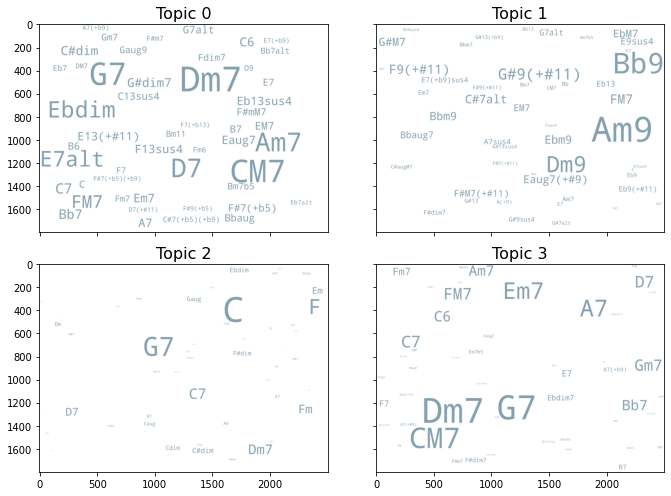

In [291]:
fig, axes = plt.subplots(2, 2, figsize=(10,7), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    #plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
#plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [292]:
from collections import Counter
topics = lda_model.show_topics(num_topics=TOTAL_TOPICS, num_words=10, formatted=False)
print(topics[0])
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([i, word , weight, counter[word]])

out

(0, [('F#m7b5', 0.33106026), ('B7(+b9)', 0.17219947), ('Em7', 0.14768645), ('Am7', 0.075796284), ('E7(+b9)', 0.059405234), ('Bm7b5', 0.046739303), ('C#m7b5', 0.037035305), ('F#7(+b9)', 0.029253254), ('Bm7', 0.017180504), ('B7', 0.010341572)])


[[0, 'F#m7b5', 0.33106026, 556],
 [0, 'B7(+b9)', 0.17219947, 278],
 [0, 'Em7', 0.14768645, 2332],
 [0, 'Am7', 0.075796284, 3512],
 [0, 'E7(+b9)', 0.059405234, 882],
 [0, 'Bm7b5', 0.046739303, 922],
 [0, 'C#m7b5', 0.037035305, 51],
 [0, 'F#7(+b9)', 0.029253254, 41],
 [0, 'Bm7', 0.017180504, 432],
 [0, 'B7', 0.010341572, 886],
 [1, 'Dm7', 0.20911555, 7037],
 [1, 'G7', 0.1952792, 9488],
 [1, 'CM7', 0.13751298, 4977],
 [1, 'A7', 0.08857411, 3208],
 [1, 'Em7', 0.086072706, 2332],
 [1, 'C7', 0.03553014, 2866],
 [1, 'FM7', 0.0337692, 1688],
 [1, 'D7', 0.03373914, 3385],
 [1, 'Gm7', 0.03216656, 1083],
 [1, 'C6', 0.026951697, 2743],
 [2, 'CM7', 0.19807993, 4977],
 [2, 'Cm7', 0.095807776, 395],
 [2, 'BbM7', 0.054335307, 286],
 [2, 'EbM7', 0.047188748, 273],
 [2, 'G#M7', 0.046792295, 346],
 [2, 'Dm7', 0.045827124, 7037],
 [2, 'Fm7', 0.04184403, 747],
 [2, 'G7', 0.033605613, 9488],
 [2, 'DM7', 0.02904588, 134],
 [2, 'C#M7', 0.028706245, 224],
 [3, 'Am7', 0.5710166, 3512],
 [3, 'E7', 0.10394688, 16

In [293]:
df = pd.DataFrame(out, columns=['topic_id', 'word',  'importance', 'word_count'])  
df     

,topic_id,word,importance,word_count
0,0,F#m7b5,0.331060,556
1,0,B7(+b9),0.172199,278
2,0,Em7,0.147686,2332
3,0,Am7,0.075796,3512
4,0,E7(+b9),0.059405,882
5,0,Bm7b5,0.046739,922
6,0,C#m7b5,0.037035,51
7,0,F#7(+b9),0.029253,41
8,0,Bm7,0.017181,432
9,0,B7,0.010342,886


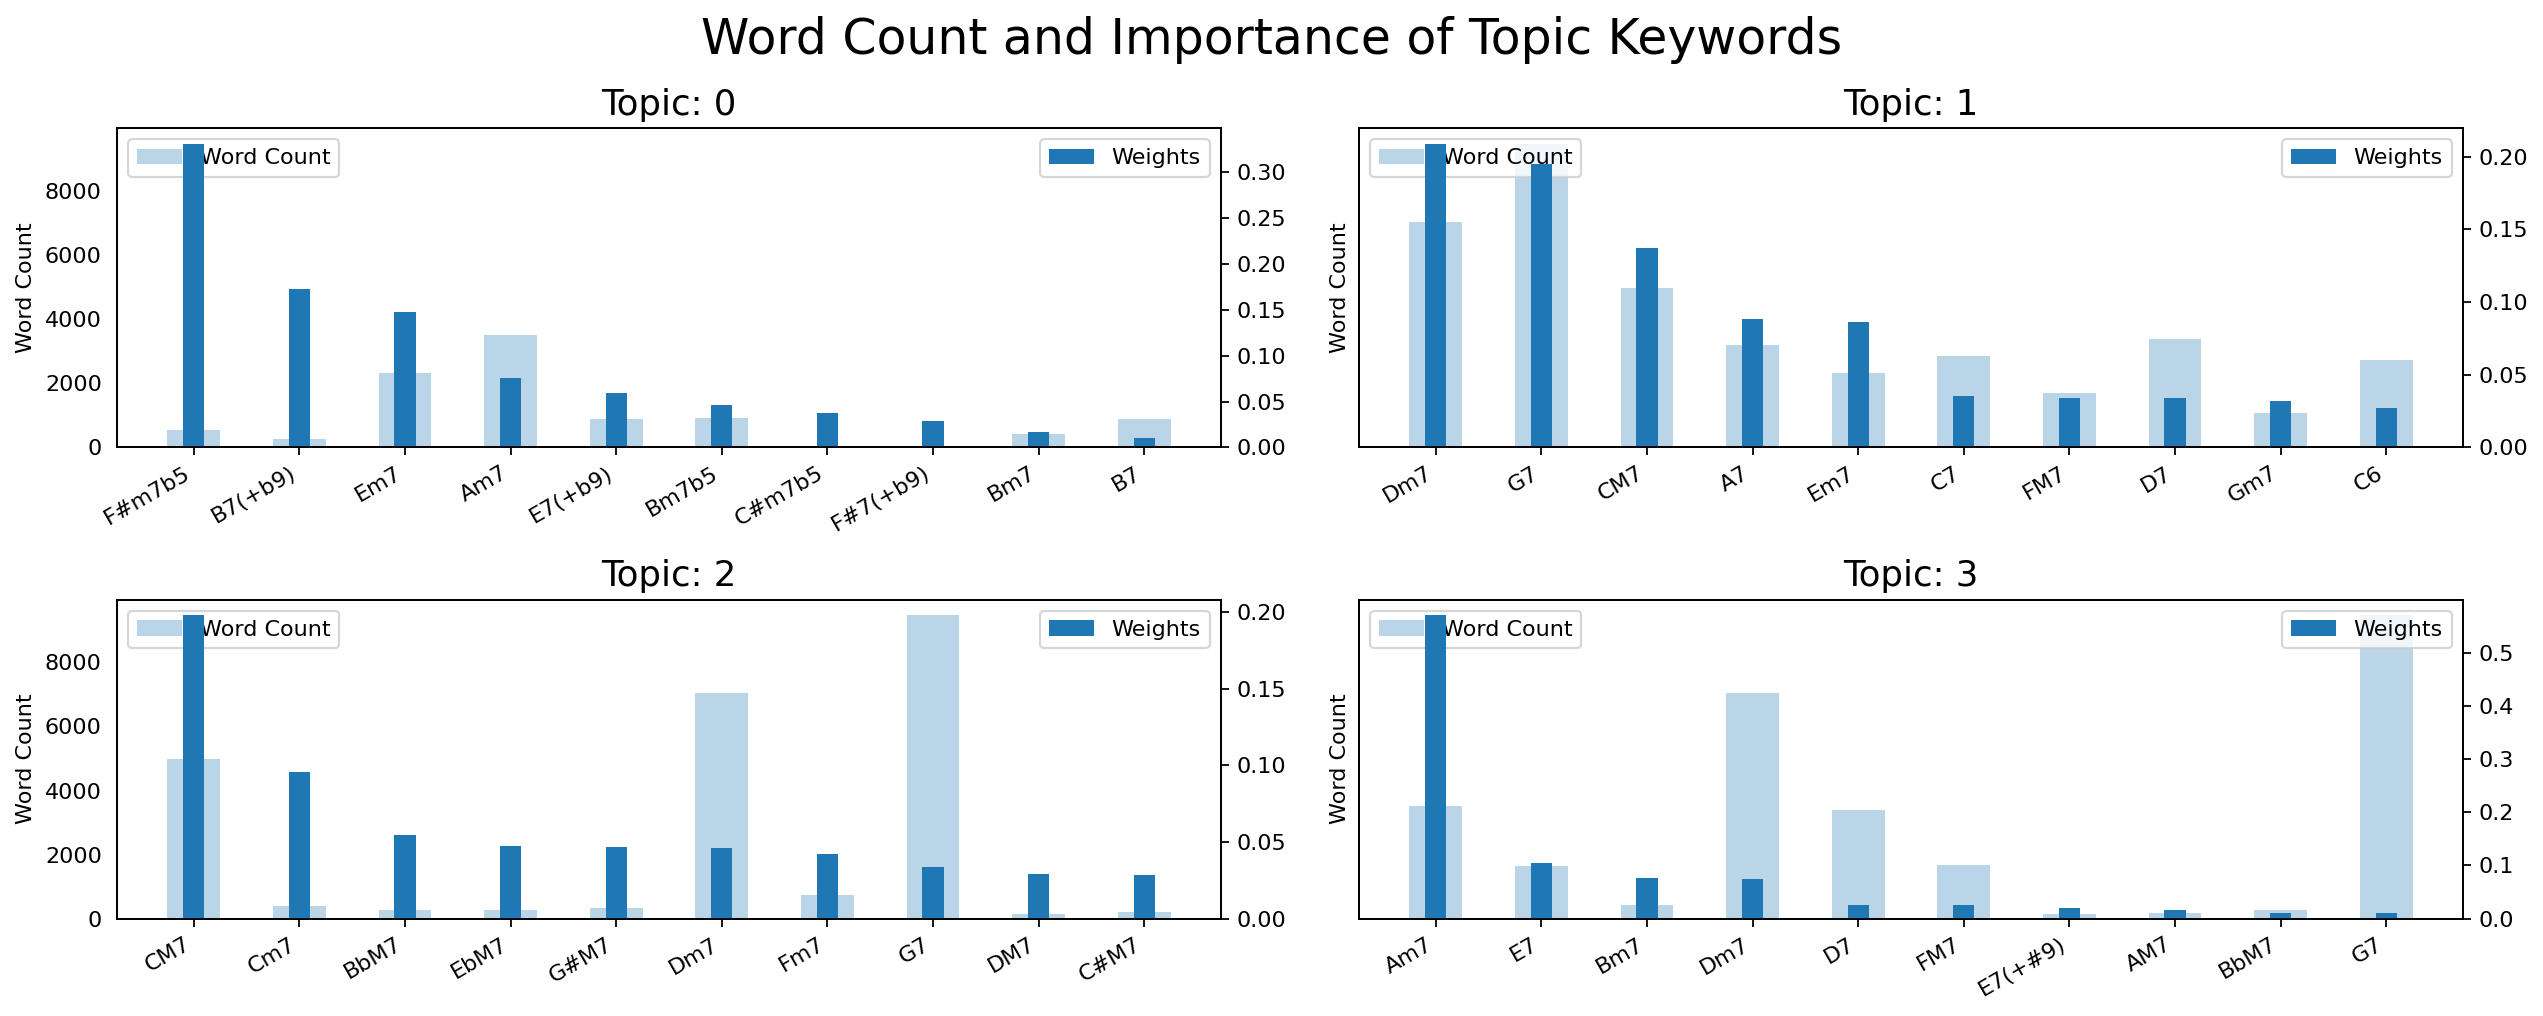

In [294]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', 
           height="word_count", 
           data=df.loc[df.topic_id==i, :], 
           #color=cols[i], 
           width=0.5, 
           alpha=0.3, 
           label='Word Count')
    
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', 
                height="importance", 
                data=df.loc[df.topic_id==i, :], 
                #color=cols[i], 
                width=0.2, 
                label='Weights')
    ax.set_ylabel('Word Count')
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    
    ax.set_title('Topic: ' + str(i), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [295]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.240613  0.107950  1       1        20.788028
4      0.231318 -0.247499  2       1        13.080122
18     0.241998 -0.263123  3       1        8.978474 
8      0.221012 -0.048489  4       1        5.974711 
6      0.228450  0.137658  5       1        5.125818 
3      0.058963  0.080843  6       1        4.889861 
5      0.066739  0.096195  7       1        3.682044 
27     0.071830  0.234388  8       1        3.062868 
10    -0.147684  0.107688  9       1        3.017814 
11    -0.010485  0.135299  10      1        2.879145 
2      0.008816  0.227209  11      1        2.788780 
9      0.077030 -0.199666  12      1        2.557416 
23     0.000794 -0.163506  13      1        2.545871 
13     0.090839  0.157535  14      1        2.312157 
21     0.091906  0.034788  15      1        1.937911 
25    -0.026680 -0.112575  16      1        1.738642 
7     -0.113742  0.151101  17      1        1.713389 
0     -0.038694  0.104571  18      1        1.550031 
12    -0.211352  0.039775  19      1        1.547582 
26    -0.151928 -0.145320  20      1        1.529410 
19     0.024421  0.089976  21      1        1.298787 
29    -0.039275 -0.181706  22      1        1.261019 
28    -0.151032 -0.083316  23      1        1.023945 
24    -0.224262 -0.038258  24      1        0.804719 
16     0.174283  0.082996  25      1        0.735777 
15    -0.230907 -0.108443  26      1        0.728508 
20    -0.168752  0.011678  27      1        0.713828 
17    -0.208449  0.008017  28      1        0.638392 
14     0.036607 -0.184390  29      1        0.589702 
22    -0.142378 -0.031377  30      1        0.505251 , topic_info=    Term         Freq        Total Category  logprob  loglift
33   C    6272.000000  6272.000000  Default  30.0000  30.0000
1    Am7  3516.000000  3516.000000  Default  29.0000  29.0000
7    CM7  4936.000000  4936.000000  Default  28.0000  28.0000
6    C7   2861.000000  2861.000000  Default  27.0000  27.0000
38   C6   2755.000000  2755.000000  Default  26.0000  26.0000
..   ..           ...          ...      ...      ...      ...
38   C6   13.956721    2755.633029  Topic30 -3.4002   0.0024 
29   Em7  10.610776    2304.532226  Topic30 -3.6743  -0.0929 
13   FM7  6.472687     1704.242591  Topic30 -4.1686  -0.2854 
111  C13  3.083590     73.984638    Topic30 -4.9101   2.1101 
33   C    3.606740     6272.542421  Topic30 -4.7534  -2.1733 

[1314 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
205   16     0.847041  A    
205   22     0.143566  A    
202   28     0.675036  A(+9)
110   19     0.629919  A13  
110   24     0.314960  A13  
...   ..          ...  ...  
294   2      0.895549  GmM7 
365   2      0.140670  Gsus4
365   9      0.140670  Gsus4
365   14     0.281340  Gsus4
365   22     0.351676  Gsus4

[1667 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 19, 9, 7, 4, 6, 28, 11, 12, 3, 10, 24, 14, 22, 26, 8, 1, 13, 27, 20, 30, 29, 25, 17, 16, 21, 18, 15, 23])

## Evaluating Topic Model Quality

We can use perplexity and coherence scores as measures to evaluate the topic
model. Typically, lower the perplexity, the better the model. Similarly, the lower the
UMass score and the higher the Cv score in coherence, the better the model.


In [296]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                      texts=data,
                                                      dictionary=id2word, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                         texts=data,
                                                         dictionary=id2word, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

2021-11-10 22:51:01,443 : INFO : using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-11-10 22:51:01,600 : INFO : WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-11-10 22:51:03,701 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021-11-10 22:51:05,069 : INFO : -3.530 per-word bound, 11.6 perplexity estimate based on a held-out corpus of 1812 documents with 82790 words


Avg. Coherence Score (Cv): 0.4556628442547333
Avg. Coherence Score (UMass): -5.060449168945664
Model Perplexity: -3.5301023252928427


with 50 topics

* Avg. Coherence Score (Cv): 0.4332256403506473
* Avg. Coherence Score (UMass): -4.76483490069454
* Model Perplexity: -3.5459273186336464

with 40 topics
* Avg. Coherence Score (Cv): 0.4560997038650477
* Avg. Coherence Score (UMass): -4.876745725502855
* Model Perplexity: -3.51271351366994

with 30 topics
* Avg. Coherence Score (Cv): 0.4556628442547333
* Avg. Coherence Score (UMass): -5.060449168945664
* Model Perplexity: -3.5301023252928427

with 25 topics
* Avg. Coherence Score (Cv): 0.4772412277166864
* Avg. Coherence Score (UMass): -4.360366950588141
* Model Perplexity: -3.5322672027301234

with 20 topics

* Avg. Coherence Score (Cv): 0.4560475354177811
* Avg. Coherence Score (UMass): -4.232610083553702
* Model Perplexity: -3.5478592184246818


### Dominant Topics in Tunes

In [297]:
corpus[0]
print(f"corpus[0] contains tune0; {corpus[0]}")
print(f"e.g. chord-id 2 appears 5 times -> chord id 2 = {id2word.id2token[2]}")

corpus[0] contains tune0; [(0, 1), (1, 1), (2, 5), (3, 1), (4, 1), (5, 1), (6, 5), (7, 5), (8, 1), (9, 2), (10, 2), (11, 5), (12, 6), (13, 4), (14, 1), (15, 6), (16, 7), (17, 4)]
e.g. chord-id 2 appears 5 times -> chord id 2 = B7


In [298]:
tm_results = lda_model[corpus] 

In [299]:
for topics in tm_results[:5]:
  print(topics)

([(1, 0.24234493), (3, 0.07861507), (7, 0.071333), (9, 0.085615665), (10, 0.4320479), (13, 0.076187015)], [(0, [3, 7]), (1, [3, 1, 13]), (2, [10, 1]), (3, [10, 7]), (4, [3, 10, 7]), (5, [7]), (6, [9, 1, 13, 7]), (7, [1, 13, 10, 3, 7]), (8, [1, 3, 13, 9]), (9, [1, 3, 10, 7, 13, 9]), (10, [3, 1, 13]), (11, [10, 1]), (12, [10, 1]), (13, [13, 1, 7, 3]), (14, [10, 13, 9, 1]), (15, [10, 7, 13]), (16, [1, 9, 10, 13, 3]), (17, [7, 1, 13])], [(0, [(3, 0.9778878), (7, 0.02200665)]), (1, [(1, 0.13198651), (3, 0.8538761), (13, 0.011814353)]), (2, [(1, 0.23745203), (10, 4.758352)]), (3, [(7, 0.05650953), (10, 0.94348615)]), (4, [(3, 0.48340964), (7, 0.04792569), (10, 0.46768013)]), (5, [(7, 0.9995922)]), (6, [(1, 0.7676581), (7, 0.021430608), (9, 4.145014), (13, 0.06194759)]), (7, [(1, 2.2623463), (3, 0.046560213), (7, 0.03187843), (10, 1.261348), (13, 1.3974332)]), (8, [(1, 0.6828844), (3, 0.15461484), (9, 0.012305235), (13, 0.15016961)]), (9, [(1, 1.6211374), (3, 0.17406857), (7, 0.07126451), (9,

In [300]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_model.show_topic(n, topn=20)] 
                   for n in range(0, lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['F#m7b5', 'B7(+b9)', 'Em7', 'Am7', 'E7(+b9)', 'Bm7b5', 'C#m7b5', 'F#7(+b9)', 'Bm7', 'B7', 'Dm7', 'FM7', 'G7', 'B7(+#9)', 'G#m7b5', 'C#m7', 'G#dim7', 'F#dim7', 'A7', 'Gm7']

Topic #2:
['Dm7', 'G7', 'CM7', 'A7', 'Em7', 'C7', 'FM7', 'D7', 'Gm7', 'C6', 'Am7', 'Bb7', 'Fm7', 'E7', 'F7', 'Ebdim7', 'B7', 'F#dim7', 'A7(+b9)', 'Em7b5']

Topic #3:
['CM7', 'Cm7', 'BbM7', 'EbM7', 'G#M7', 'Dm7', 'Fm7', 'G7', 'DM7', 'C#M7', 'Em7', 'D7(+#11)', 'AM7', 'Bb7', 'G7(+b9)', 'Bbm7', 'GM7', 'Cm6', 'Eb7', 'C#9(+#11)']

Topic #4:
['Am7', 'E7', 'Bm7', 'Dm7', 'D7', 'FM7', 'E7(+#9)', 'AM7', 'BbM7', 'G7', 'CM7', 'E7(+b13)', 'Bm7b5', 'F7', 'A6', 'Em7', 'C#m7', 'Esus4', 'F#m7b5', 'DM7']

Topic #5:
['C', 'G7', 'F', 'C7', 'Dm7', 'Fm', 'D7', 'Em', 'C#dim', 'Ebdim', 'F#dim', 'Cdim', 'Gaug', 'Dm', 'Caug', 'A7', 'Am', 'B7', 'Gdim', 'G']

Topic #6:
['G#7', 'Bb7', 'Ebm7', 'Fm7', 'CM7', 'Dm7', 'G7', 'C#M7', 'C7', 'EbM7', 'Bb7(+#11)', 'F#7', 'D7', 'Gm7', 'Gaug7', 'Eb7', 'G7(+#11)', 'G7(+b13)', 'F7', 'FM7']

Topic #7

In [301]:
len(topics)

30

In [302]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Term1,F#m7b5,Dm7,CM7,Am7,C,G#7,Dm7,Gm7,C6,C7,F#m7,Bm7b5,C6(+9),CM7,Gaug,CM7(+#11),Dm7,Am9,C,E7(+b9),F7(+#11),A7(+b9),Cdim7,Am,D13,B7,F7,CM7,D9,G
Term2,B7(+b9),G7,Cm7,E7,G7,Bb7,G7,BbM7,G7,F7,EM7,E7(+b9),G13,FM7,C7(+b9)sus4,Dm11,G7,Bb9,D7,Am,G9,Em7b5,G13(+b9),E7,C13,E,C7sus4,G7sus4,C#7,F
Term3,Em7,CM7,BbM7,Bm7,F,Ebm7,CM7,Cm7,D7,G7,G#M7,Am7,B,G7(+b9),Gm6,FM7(+#11),CM7,Dm9,G7,Bm7b5,C7(+#9),Dm7,B7alt,Dm,F9,Bb7,Am(+b6),Dm7,Eb7,G#
Term4,Am7,A7,EbM7,Dm7,C7,Fm7,Ebdim7,Fm7,Dm7,Am11,Bbm7,Am6,E6,Em7,D7,BbM7(+#11),Am7,G#9(+#11),A7,AmM7,G9sus4,F#m7b5,Dm9,B7,D7sus4,C7,G7(+#9),Dm7b5,Bb7,C
Term5,E7(+b9),Em7,G#M7,D7,Dm7,CM7,C6,C7(+b9),F6,Cm,Eb7,E7(+b13),F#7,Fm7,E9,C9,D7,FM7,E7,Dm7,F7sus4,B7(+b9),G13sus4,D7,G9,F#m7,B7(+#9),Fm6,Bb13,Bb
Term6,Bm7b5,C7,Dm7,FM7,Fm,Dm7,C#dim7,C#M7,A7,Gm,C#m7,Dm7,F13,D7,G#dim,C#M7(+#11),Ebdim,F9(+#11),Dm,FM7,C#7(+#9),G7,C6,D6,Gm9,A,F#7,G7(+b9),D7,D
Term7,C#m7b5,FM7,Fm7,E7(+#9),D7,G7,Em7,FM7,F#dim7,Dm7,Em7,Dm6,Aaug7,Eaug7,Aaug,Bb9(+#11),E7alt,C#7alt,F,G7,F#m7,D7,Em7,Em,Gm11,A7,Eaug7,Em7,G13,C#
Term8,F#7(+b9),D7,G7,AM7,Em,C#M7,FM7,Dm7,C7,Bbm11,B7,FM7,G9,FmM7,FM9,F#M7(+#11),FM7,Ebm9,C7,CM7,A9,CM7,Gm7,G7,Fm9,A7sus4,E7(+#9),FM7,C9,CM9
Term9,Bm7,Gm7,DM7,BbM7,C#dim,C7,Fm6,E7(+#9),Am7,Bb7,G#m7,Gm7,F9,G7,C7,Em11,C7,Bbm9,Ebdim,Eb9sus4,Em7,Dm,Bb13,A7,G#9,E7,Edim7,Gaug7,B13,E
Term10,B7,C6,C#M7,G7,Ebdim,EbM7,Gaug7,Eb,F7,Fm,CM7,F7,F#m7,Gaug7,C,G#M7(+#11),Bb7,G#M7,Dm7,Em7,Dm7,B7(+b13),A7sus4,Dm6,G13,Dm7,GM9,Gm7,C#9,Eb


In [303]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['TermsPerTopic'],
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)]
                         )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,TermsPerTopic
Topic1,"F#m7b5, B7(+b9), Em7, Am7, E7(+b9), Bm7b5, C#m7b5, F#7(+b9), Bm7, B7, Dm7, FM7, G7, B7(+#9), G#m7b5, C#m7, G#dim7, F#dim7, A7, Gm7"
Topic2,"Dm7, G7, CM7, A7, Em7, C7, FM7, D7, Gm7, C6, Am7, Bb7, Fm7, E7, F7, Ebdim7, B7, F#dim7, A7(+b9), Em7b5"
Topic3,"CM7, Cm7, BbM7, EbM7, G#M7, Dm7, Fm7, G7, DM7, C#M7, Em7, D7(+#11), AM7, Bb7, G7(+b9), Bbm7, GM7, Cm6, Eb7, C#9(+#11)"
Topic4,"Am7, E7, Bm7, Dm7, D7, FM7, E7(+#9), AM7, BbM7, G7, CM7, E7(+b13), Bm7b5, F7, A6, Em7, C#m7, Esus4, F#m7b5, DM7"
Topic5,"C, G7, F, C7, Dm7, Fm, D7, Em, C#dim, Ebdim, F#dim, Cdim, Gaug, Dm, Caug, A7, Am, B7, Gdim, G"
Topic6,"G#7, Bb7, Ebm7, Fm7, CM7, Dm7, G7, C#M7, C7, EbM7, Bb7(+#11), F#7, D7, Gm7, Gaug7, Eb7, G7(+#11), G7(+b13), F7, FM7"
Topic7,"Dm7, G7, CM7, Ebdim7, C6, C#dim7, Em7, FM7, Fm6, Gaug7, A7(+b13), Am7, D7, Caug7, Bb7(+#11), C7, Caug, F6, A7(+b9), Gm7"
Topic8,"Gm7, BbM7, Cm7, Fm7, C7(+b9), C#M7, FM7, Dm7, E7(+#9), Eb, D7(+b9), EbM7, Bbm7, Gm7b5, A7(+#9), D7(+#9), G#M7(+#11), G#M7, Eb7sus4, Em9"
Topic9,"C6, G7, D7, Dm7, F6, A7, F#dim7, C7, Am7, F7, E7, Gm7, G#7, Gaug7, Bb6, Fm6, Bb7, FM7, Ebm6, G6"
Topic10,"C7, F7, G7, Am11, Cm, Gm, Dm7, Bbm11, Bb7, Fm, Bbm, Am7b5, D7(+b5), D7, G#7, F, D7(+#11), G#7(+b9), C#7alt, F#7alt"


In [304]:
for topics in tm_results[:5]:
  print(topics)

([(1, 0.24230193), (3, 0.078603186), (7, 0.071348295), (9, 0.08560501), (10, 0.43201214), (13, 0.076272994)], [(0, [3, 7]), (1, [3, 1, 13]), (2, [10, 1]), (3, [10, 7]), (4, [3, 10, 7]), (5, [7]), (6, [9, 1, 13, 7]), (7, [1, 13, 10, 3, 7]), (8, [1, 3, 13, 9]), (9, [1, 3, 10, 7, 13, 9]), (10, [3, 1, 13]), (11, [10, 1]), (12, [10, 1]), (13, [13, 1, 7, 3]), (14, [10, 13, 9, 1]), (15, [10, 7, 13]), (16, [1, 9, 10, 13, 3]), (17, [7, 1, 13])], [(0, [(3, 0.977879), (7, 0.02201548)]), (1, [(1, 0.13198233), (3, 0.8538626), (13, 0.011831075)]), (2, [(1, 0.23742922), (10, 4.758369)]), (3, [(7, 0.056526925), (10, 0.9434687)]), (4, [(3, 0.48338115), (7, 0.04794253), (10, 0.46769187)]), (5, [(7, 0.9995924)]), (6, [(1, 0.7676132), (7, 0.021438489), (9, 4.1449647), (13, 0.06203361)]), (7, [(1, 2.2613683), (3, 0.04654082), (7, 0.03187823), (10, 1.2609284), (13, 1.3988503)]), (8, [(1, 0.6827339), (3, 0.15458322), (9, 0.012303098), (13, 0.15035377)]), (9, [(1, 1.6210747), (3, 0.17406459), (7, 0.071292125)

In [305]:
corpus_topics = [sorted(topics[0], key=lambda record: -record[1])[0] for topics in tm_results]
#corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

corpus_topics[:10]



[(10, 0.43201053),
 (7, 0.753698),
 (7, 0.38175565),
 (4, 0.66276735),
 (8, 0.40238535),
 (1, 0.19547357),
 (1, 0.5367826),
 (6, 0.694217),
 (1, 0.5987085),
 (13, 0.24400492)]

In [306]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(data))
corpus_topic_df['DominantTopic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution%'] = [round(item[1]*100, 2) for item in corpus_topics]
#corpus_topic_df['TopicDesc'] = [topics_df.iloc[t[0]]['TermsPerTopic'] for t in corpus_topics]
corpus_topic_df['Tunes'] = data

In [307]:
corpus_topic_df['Title'] = titles['title']

In [308]:
corpus_topic_df

,Document,DominantTopic,Contribution%,Tunes,Title
0,0,11,43.20,"[CM7, Eb7, G#M7, B7, EM7, G7, Gm7, C7, FM7, G#7, C#M7, E7, Am7, D7, Dm7, G7, CM7, Eb7, G#M7, B7, EM7, G7, Gm7, C7, FM7, Eb7, G#M7, B7, EM7, G7, CM7, Gm7, C7, Bm7, E7, AM7, C7, FM7, Bbm7, Eb7, G#M7, Dm7, G7, CM7, Eb7, G#M7, B7, EM7, G7, Gm7, C7, FM7, Eb7, G#M7, B7, EM7, G7, CM7]",26-2
1,1,8,75.37,"[Am7, Am7, Cm7, Cm7, EbM7, EbM7, Em7b5, A7(+#9), Dm7, Dm7, Bm7b5, Bm7b5, Bbm7, Bbm7, Fm7, Fm7, E7(+#9), E7(+#9), Fm7, Fm7, C#M7, C#M7, Fm7, Fm7, C#M7, C#M7]",500 Miles High
2,2,8,38.18,"[Am7, C#M7, Bm7b5, E7(+#9), Am7, C#M7, Bm7b5, E7(+#9), Cm7, F7(+b9), BbM7, G#m7, C#7, F#m7b5, B7(+b9), EaugM7, EaugM7, E7, Am7, C#M7, Bm7b5, E7(+#9), Am7, C#M7, Bm7b5, E7(+#9), Cm7, F7(+b9), BbM7, G#m7, C#7, F#m7b5, B7(+b9), Em7, Em7]",502 Blues
3,3,5,66.28,"[C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, G7, C, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, G7, C, C7, C7, F6, F6, D7, D7, G7, G7, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, G7, C]",52nd Street Theme
4,4,9,40.24,"[C9, Ebm6, C9, Ebm6, Bb, Bb7, A7, G#7, G7, C9, F#dim7, C9, G#7, G7, C9, Ebm6, C9, Ebm6, Bb, Bb7, A7, G#7, G7, C9, F#dim7, C9, F7, Bb, Bb, Eb, Eb6, Eb6, Eb6, G9, F, F6, F9, F7, C9, Ebm6, C9, Ebm6, Bb, Bb7, A7, G#7, G7, C9, F#dim7, C6, F7, Bb, D9]",9.20 Special
...,...,...,...,...,...
1807,1807,5,83.37,"[C, C, C#dim, G7, G7, G7, G7, C, C#dim, G7, Dm7, G7, C, C, C#dim, G7, G7, G7, G7, C, Dm7, C, E, F, FM7, F#dim, C, C, B7, B7, Em, B7, Dm7, G7, C, C, C#dim, G7, G7, G7, G7, C, Ebdim, G7, Dm7, G7]",You're Foolin' Someone
1808,1808,19,49.53,"[Dm7, G7, Em7b5, A7, Dm7, G#7, G7, C, C, Dm7, G7, Em7b5, A7, Dm7, G#7, G7, C, C, A7, A7, A7, A7, Dm7, G7(+b9), D7, G7, Dm7, G7, Em7b5, A7, Dm7, G#7, G7, C, C]",You're Lucky To Me
1809,1809,19,75.96,"[C, E7, A7, A7, Dm, G7, C, Em7, C, G7, Em7, Cdim, Dm7, Dm7, Dm7, D7, Dm7, G7, Dm7, G7, C, E7, A7, A7, Dm, A7, Dm, A7, Dm, F, Cdim, C, E7, Dm, D7, G7, C, C]",You're Nobody Till Somebody Loves You
1810,1810,5,68.44,"[G7, G7, C, C, G7, G7, C, F, G#, C, C, G7, G7, C, F, C, C, G7, C, G7, F7, F7, F7, C, F7, F7, C, C, F7, F7, F7, C, F7, F7, C, F, C]",Your Feet's Too Big


In [309]:
corpus_topic_df.groupby('DominantTopic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution%'], 
                                                                                         ascending=False)
                                                                             .iloc[0])
)


,Document,DominantTopic,Contribution%,Tunes,Title
DominantTopic,,,,,
1,1284,1,84.22,"[Am7, Am7, F#m7b5, B7(+b9), Em7, Em7, C#m7b5, F#7(+b9), Bm7, G#m7b5, C#m7b5, F#7(+b9), Bm7, C#m7, Dm7, E7(+b9), Am7, Am7, F#m7b5, B7(+b9), Em7, Em7, C#m7b5, F#7(+b9), Bm7, G#m7b5, C#m7b5, F#7(+b9), Bm7, C#m7, Dm7, G7, F#m7b5, B7(+b9), Em7, Em7, C#m7b5, F#7(+b9), Bm7b5, E7(+b9), Am7, Am7, F#m7b5, B7(+b9), Em7, Em7, C#m7b5, F#7(+b9), Bm7, G#m7b5, C#m7b5, F#7(+b9), Bm7, C#m7, Dm7, E7(+b9)]",Whisper Not
2,304,2,98.18,"[CM7, A7, Dm7, G7, Em7, A7, Dm7, G7, Gm7, C7, FM7, Bb7, Em7, A7, Dm7, G7, CM7, A7, Dm7, G7, Em7, A7, Dm7, G7, Gm7, C7, FM7, Bb7, Dm7, G7, C6, E7, E7, A7, A7, D7, D7, G7, G7, CM7, A7, Dm7, G7, Em7, A7, Dm7, G7, Gm7, C7, FM7, Bb7, Dm7, G7, C6]",Dexterity
3,660,3,95.53,"[Caug7, Caug7, Caug7, Caug7, Caug7, Caug7, Caug7, Caug7, Baug7, Baug7, Bb7, Bb7, AM7, AM7, Fm7, Fm7, F#M7, F#M7, Cm7, Cm7, F#M7, F#M7, Cm7, Cm7]",Juju
4,731,4,97.80,"[Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, BbM7, BbM7, BbM7, BbM7, AM7, AM7, AM7, AM7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, BbM7, BbM7, BbM7, BbM7, AM7, AM7, AM7, AM7]",Little Sunflower
5,1410,5,98.46,"[C, C, C, C, C, G7, C, C7, F, F, C, C, G7, G7, C, C, F, F, C, C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C7, F, F#dim7, C, A7, D7, G7, C, F, F, C, C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C, C, C, C, C, C, G7, C]",Bogalusa Strut
6,12,6,82.22,"[Bb7(+#11), Bb7(+#11), Bb7(+#11), Bb7(+#11), A7(+b13), D7, G7(+b13), C7, C#M7, D7, C#M7, C6, Bb7(+#11), Bb7(+#11), Bb7(+#11), Bb7(+#11), A7(+b13), D7, G7(+b13), C7, C#M7, D7, C#M7, C6, Dm7, Gaug7, CM7, Ebm7, G#7(+b9), C#M7, Gm7b5, Caug7, C#M7, G7(+#11), F#7(+#11), FM7, G7(+#11), Bb7(+#11), Bb7(+#11), Bb7(+#11), Bb7(+#11), A7(+b13), D7, G7(+b13), C7, C#M7, D7, C#M7, C6]",A Flower Is A Lovesome Thing
7,787,7,93.99,"[C6, C6, B7sus4, B7, C6, C6, Em7, A7(+b13), Dm7, Dm7, Fm6, Fm6, Em7, A7(+b13), Dm7, Gaug7, C6, C6, B7sus4, B7, C6, C6, Em7, A7(+b13), Dm7, Dm7, Fm6, Fm6, Em7, A7(+b13), Dm7, Gaug7, FM7, FM7, Fm6, Fm6, Em7, Ebdim7, Dm7, Gaug7, Em7, A7(+b13), Dm7, G7, C6, Dm7, G7]",Meditation
8,984,8,87.43,"[C6(+9), Caug, F#aug, BbM7, Fm7, Fm7, Cm9, Cm9, FmM7, Cm11, Fm7, BbaugM7, FmM7, BbM7, Fm7, C#]",Re Person I Knew
9,22,9,97.07,"[F#dim7, F6, C6, C6, F#dim7, F6, C6, C6, F#dim7, F6, C6, C6, D7, G7, C6, F#dim7, F6, C6, C6, F#dim7, F6, C6, C6, F#dim7, F6, C6, C6, D7, G7, C6, C7, F6, F#dim7, C6, Gm7, C7, F6, F#dim7, C6, A7(+b9), Dm7b5, G7, F#dim7, F6, C6, C6, F#dim7, F6, C6, C6, F#dim7, F6, C6, C6, D7, G7, C6]",A Smooth One


In [310]:
corpus_topic_df.value_counts('DominantTopic')

DominantTopic
2     487
5     325
19    178
9     105
7     92 
4     70 
10    54 
3     52 
28    47 
12    46 
6     45 
11    43 
24    32 
8     31 
14    31 
20    30 
13    20 
30    15 
16    14 
21    12 
17    12 
25    12 
26    11 
27    11 
18    9  
1     9  
22    6  
29    6  
23    5  
15    2  
dtype: int64

### List the Tunes of the individual Topics

In [311]:
def display_tunes_per_topic(df, topic):
  tunes = df.query(f"DominantTopic == {topic}").sort_values('Contribution%', ascending=False)
  print(f"\n*** TOPIC {n} ***")
  print(f"{len(tunes)} tunes")
  return tunes


In [312]:
topic_result = corpus_topic_df.loc[:, ['DominantTopic', 'Contribution%', 'Title', 'Tunes']]

In [313]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [314]:
for n in range(1, TOTAL_TOPICS+1):
  print(display_tunes_per_topic(topic_result, topic=n).head(30))


*** TOPIC 1 ***
9 tunes
      DominantTopic  Contribution%                               Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Tunes
1284  1              84.22          Whisper Not                         [Am7, Am7, F#m7b5, B7(+b9), Em7, Em7, C#m7b5, F#7(+b9), Bm7, G#m7b5, C#m7b5, F#7(+b9), Bm7, C#m7, Dm7, E7(+b9), Am7, Am7, F#m7b5, B7(+b9), Em7, Em7, C#m7b5, F#7(+b9), Bm7, G#m7b5, C#m7b5, F#7(+b9), Bm7, C#m7, Dm7, G7, F#m7b5, B7(+b9), Em7, Em7, C#m7b5, F#7(+b9), Bm7b5, E7(+b9), Am7, Am7, F#m7b5, B7(+b9), Em7, Em7, C#m7b5, F#7(+b9), Bm7, G#m7b5, C#m7b5, F#7(+b9)